In [ ]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# LazyClassifier for quick model benchmarking
!pip install lazypredict               # Install if necessary/Giving Error while importing LazyClassifier
from lazypredict.Supervised import LazyClassifier

# === PCA with RandomForest Pipeline ===

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


# ANN + SMOTE
#!pip install tensorflow     #install if needed

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

!pip install scikit-fuzzy # install if necessary
import skfuzzy as fuzz
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.stats import mode

# For scatter matrix plots
from pandas.plotting import scatter_matrix

# For explainability analysis
import shap
import pickle



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 14.5 MB/s eta 0:00:00


In [ ]:

# Load the pre-split training and testing datasets
train_path = "/content/UNSW_NB15_training-set.csv"
test_path = "/content/UNSW_NB15_testing-set.csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Combine for unified processing (optional)
df = pd.concat([df_train, df_test], ignore_index=True)
# Reduce sample size for quicker execution
df = df.sample(n=20000, random_state=42).copy()

# Preview dataset
df.head()


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
122637,40306,0.05,tcp,-,FIN,42,42,2646,23508,1627.96,...,1,1,0,0,0,3,4,0,Normal,0
137118,54787,0.00,pgm,-,INT,2,0,200,0,125000.00,...,1,6,0,0,0,8,6,0,Analysis,1
245289,162958,0.00,udp,dns,INT,2,0,114,0,333333.32,...,17,17,0,0,0,18,17,0,Generic,1
221262,138931,0.00,udp,dns,INT,2,0,114,0,333333.32,...,14,36,0,0,0,32,36,0,Generic,1
31408,31409,1.43,tcp,http,FIN,14,18,1684,10168,21.66,...,1,1,0,0,1,1,2,0,Normal,0


In [ ]:
#Basic EDA
print("=== Dataset Info ===")
df.info()

print("\n=== Statistical Summary ===")
print(df.describe())

print("\n=== Missing Values per Column ===")
print(df.isnull().sum())


print("\n=== Target Variable Distribution ===")
print(df['label'].value_counts(normalize=True))

=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 122637 to 180285
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 20000 non-null  int64  
 1   dur                20000 non-null  float64
 2   proto              20000 non-null  object 
 3   service            20000 non-null  object 
 4   state              20000 non-null  object 
 5   spkts              20000 non-null  int64  
 6   dpkts              20000 non-null  int64  
 7   sbytes             20000 non-null  int64  
 8   dbytes             20000 non-null  int64  
 9   rate               20000 non-null  float64
 10  sttl               20000 non-null  int64  
 11  dttl               20000 non-null  int64  
 12  sload              20000 non-null  float64
 13  dload              20000 non-null  float64
 14  sloss              20000 non-null  int64  
 15  dloss              20000 non-null  int64  
 16  

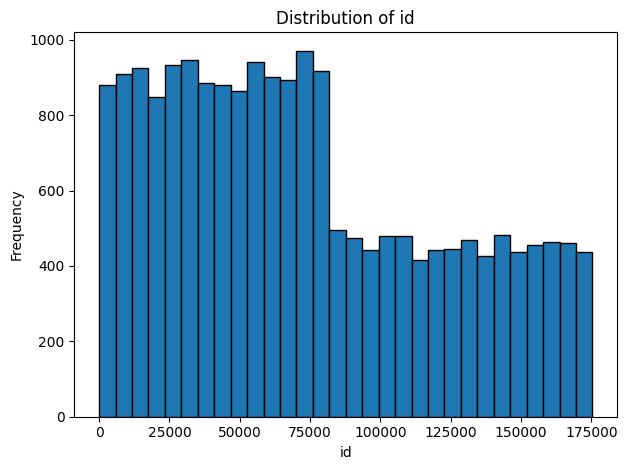

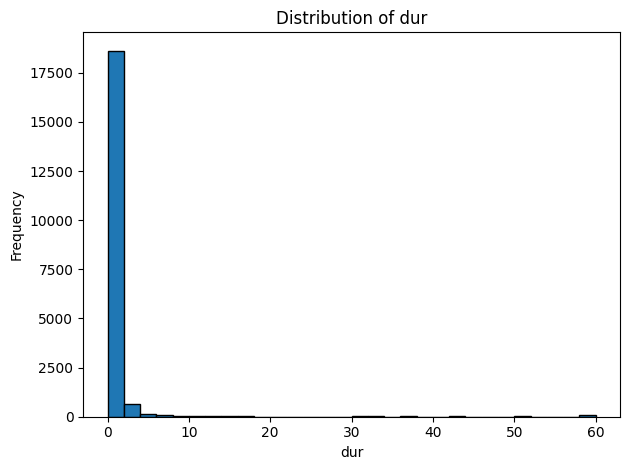

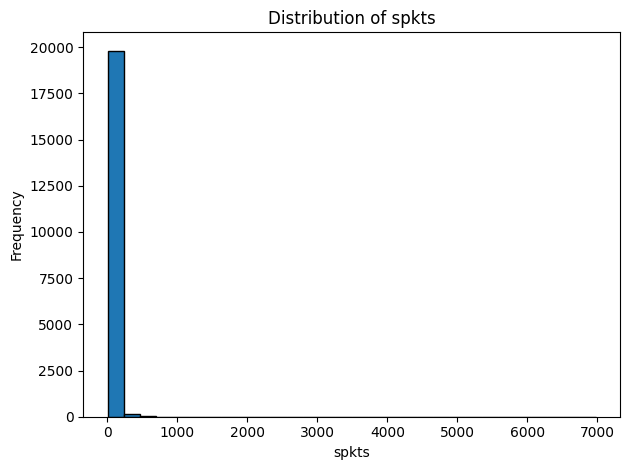

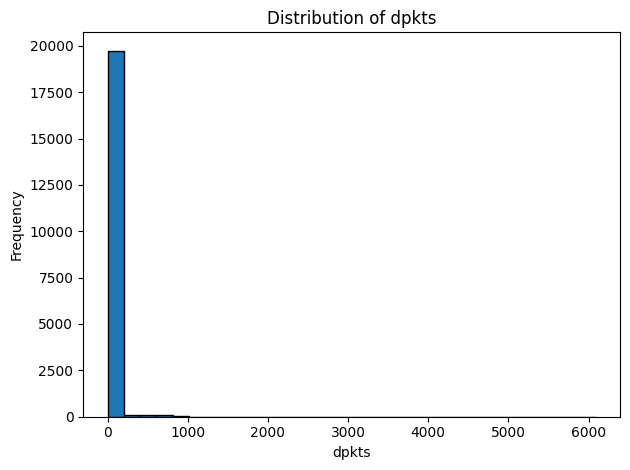

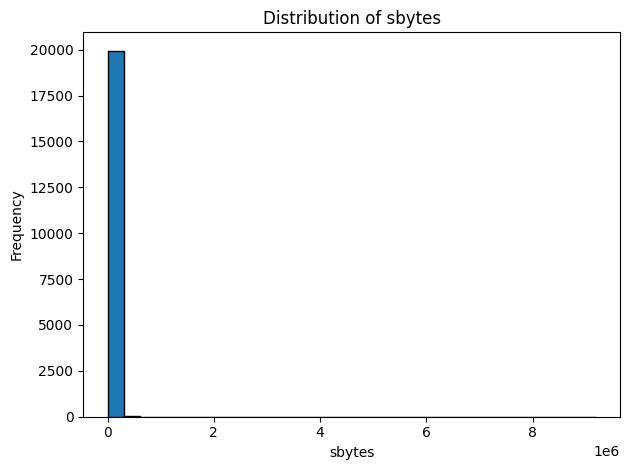

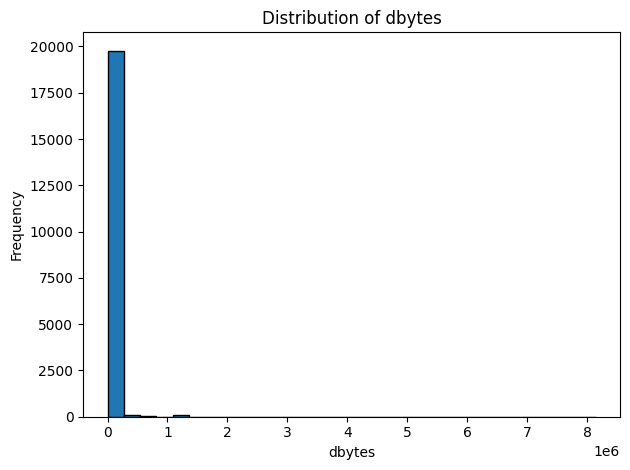

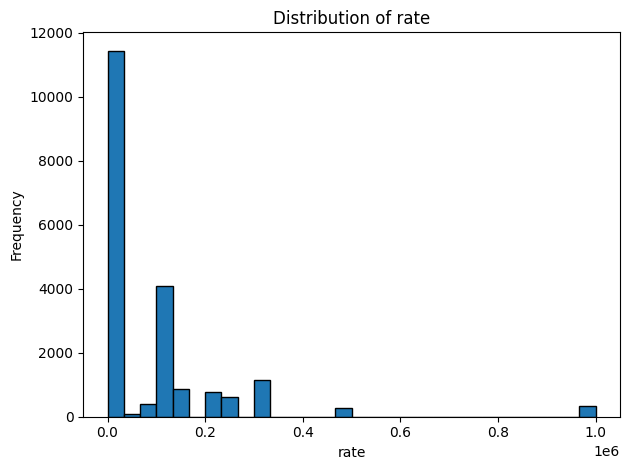

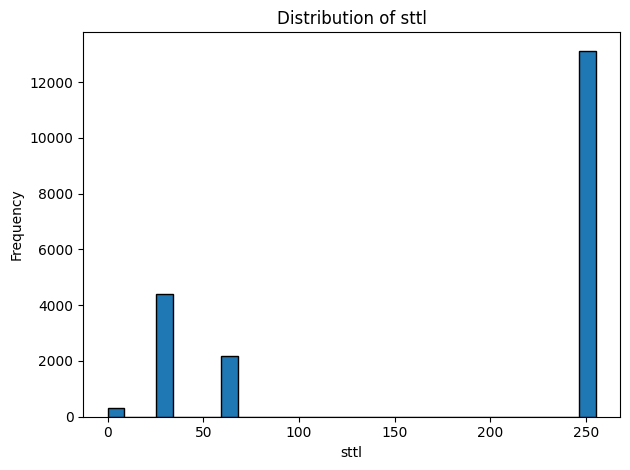

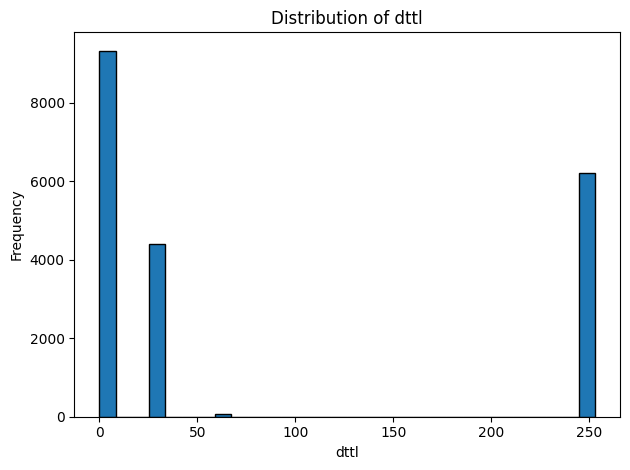

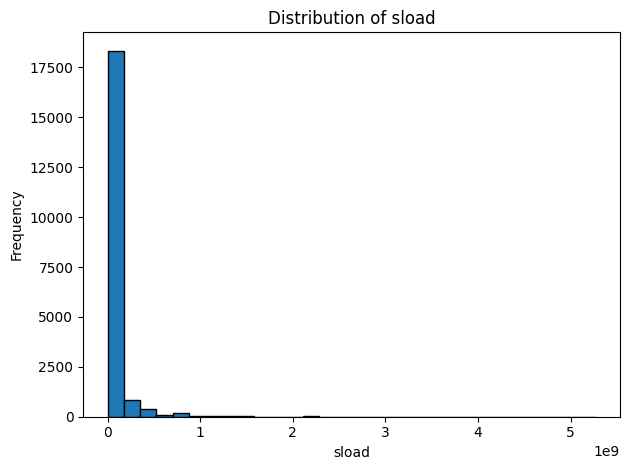

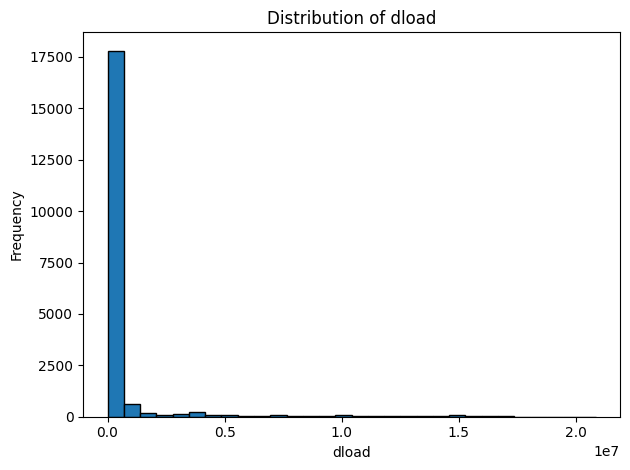

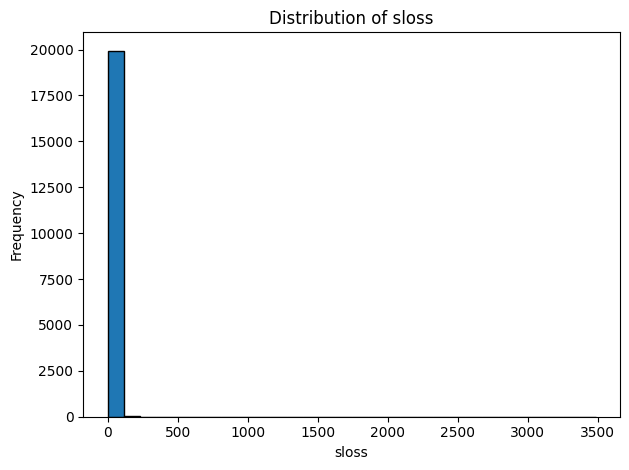

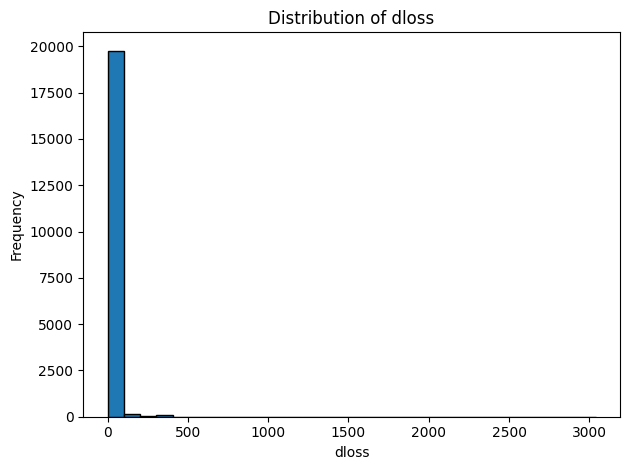

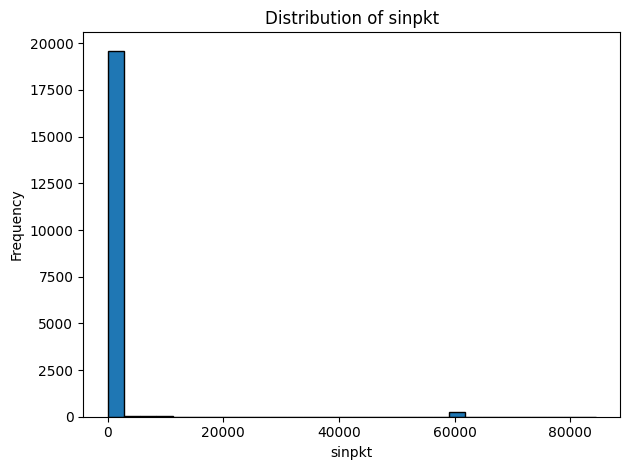

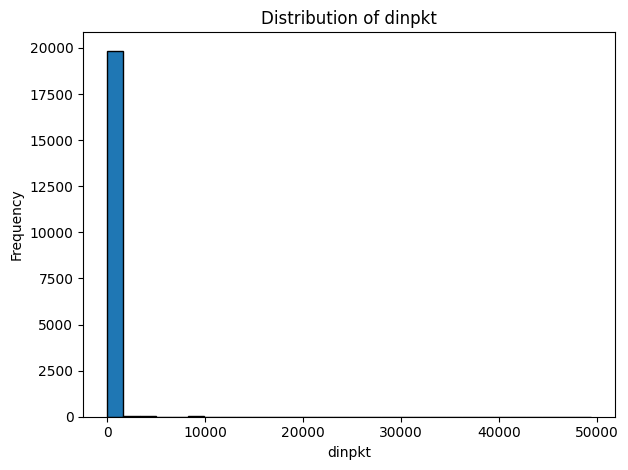

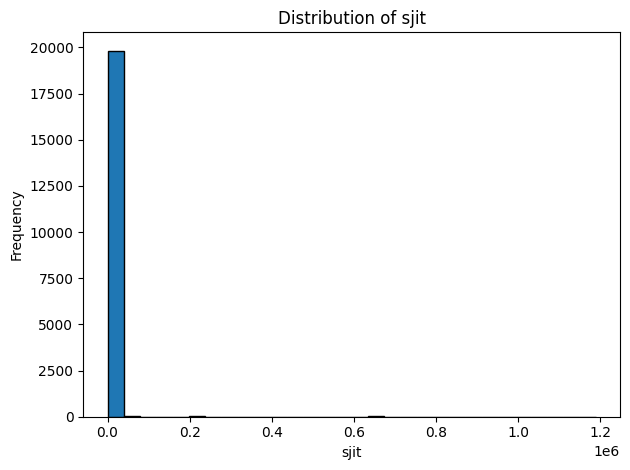

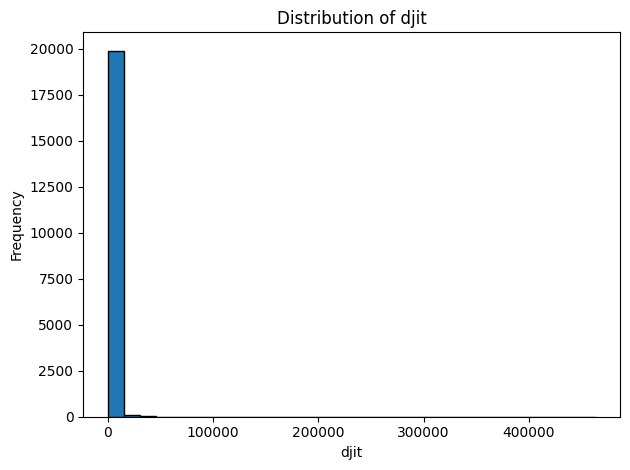

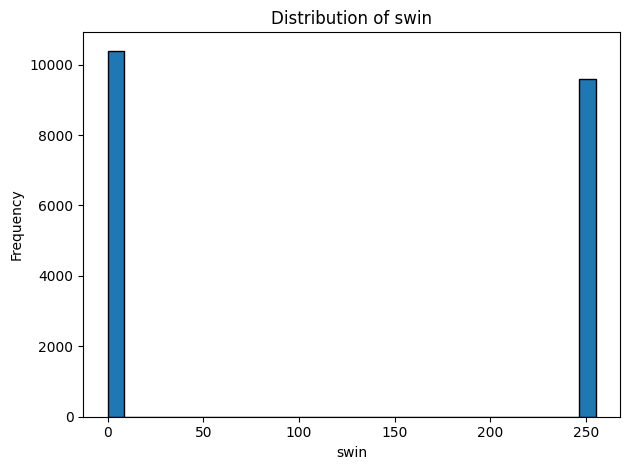

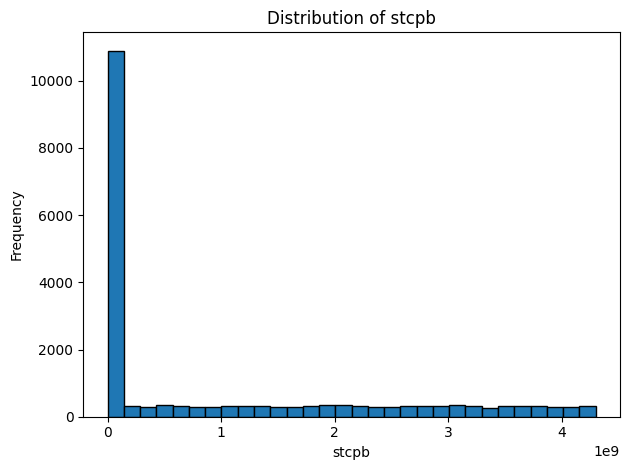

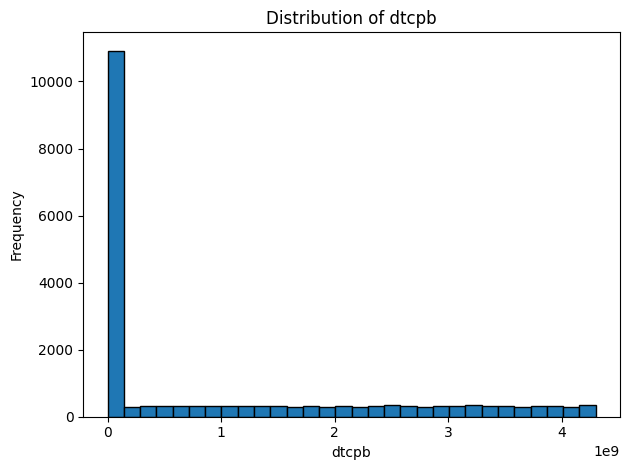

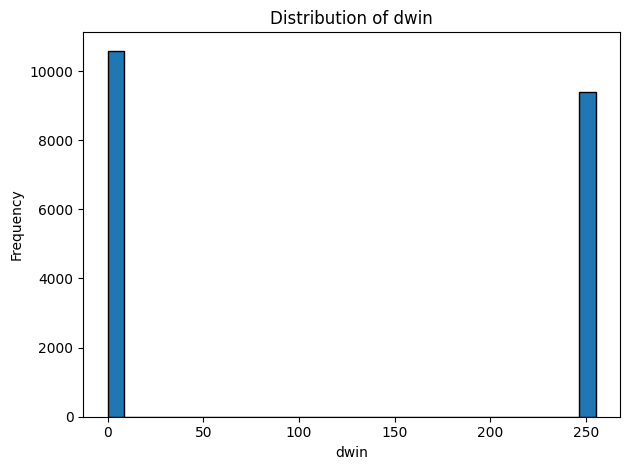

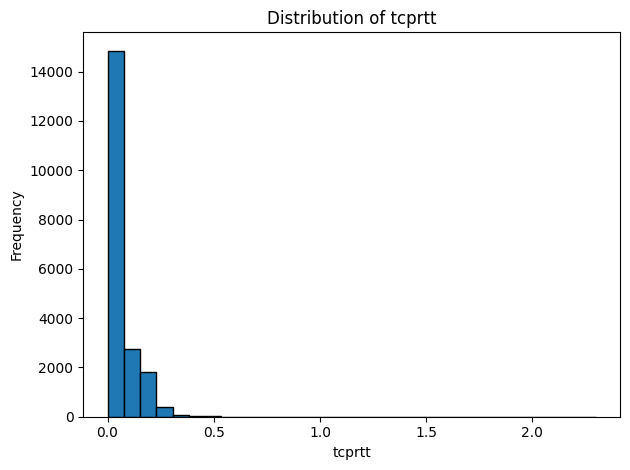

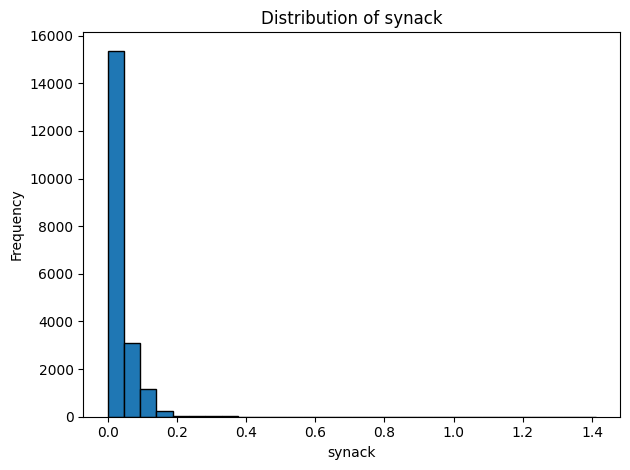

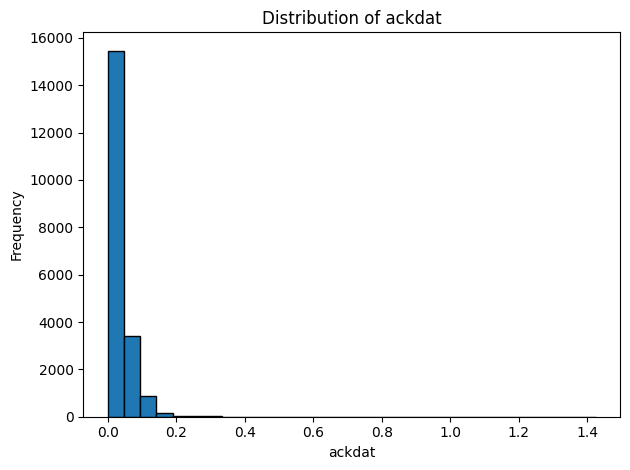

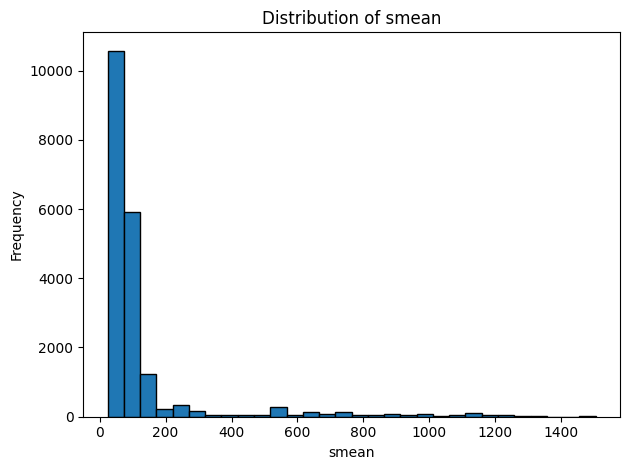

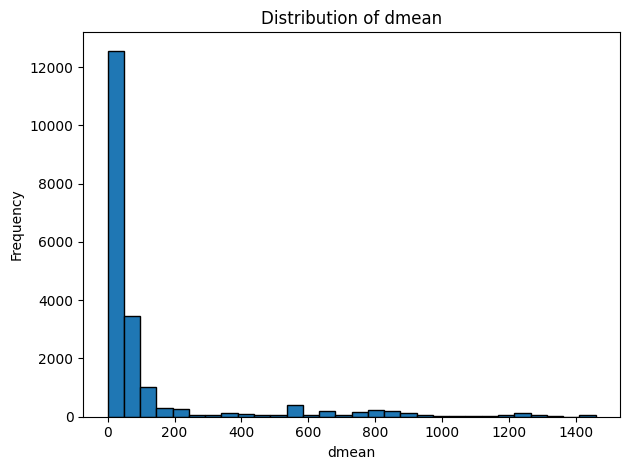

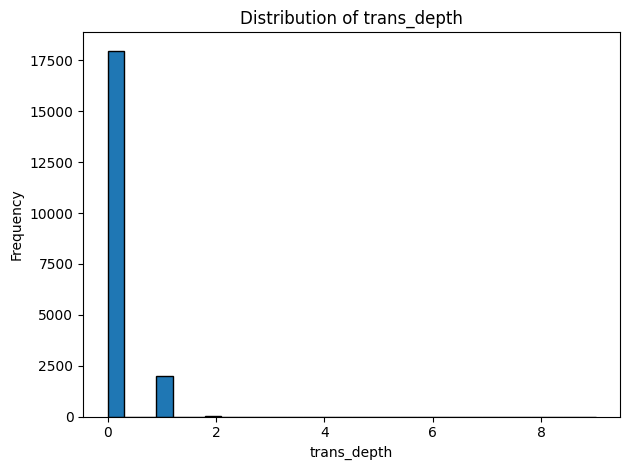

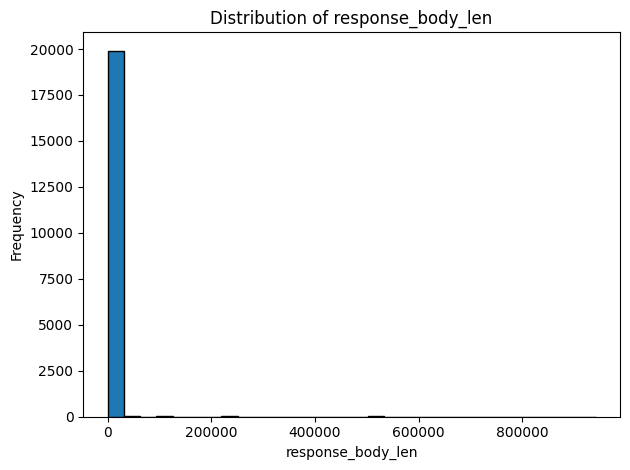

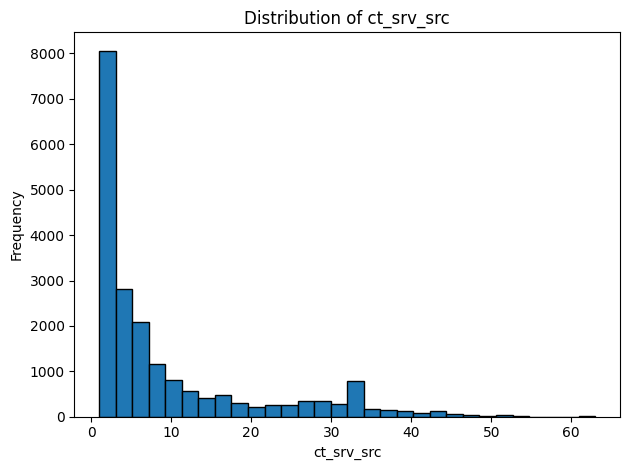

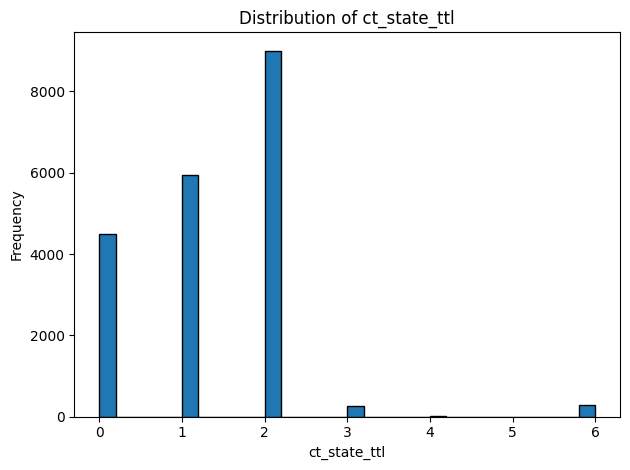

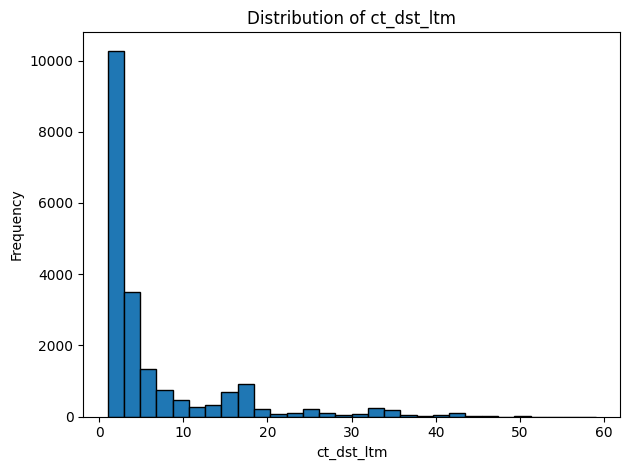

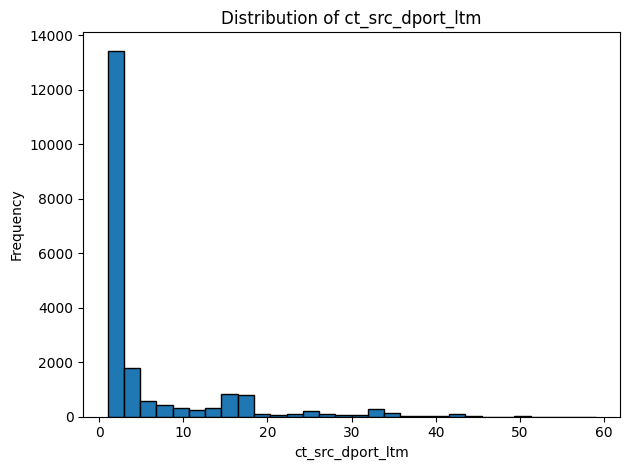

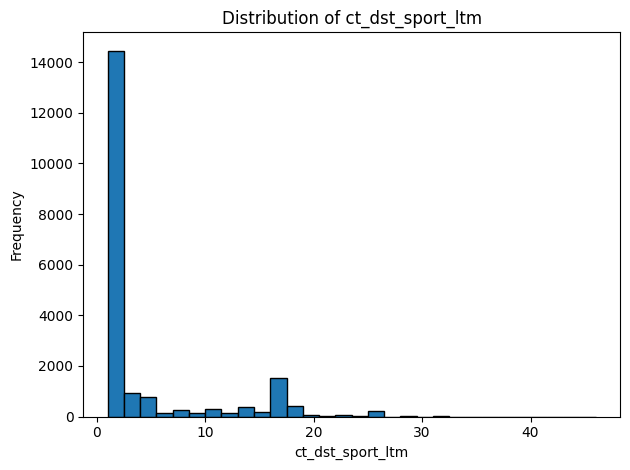

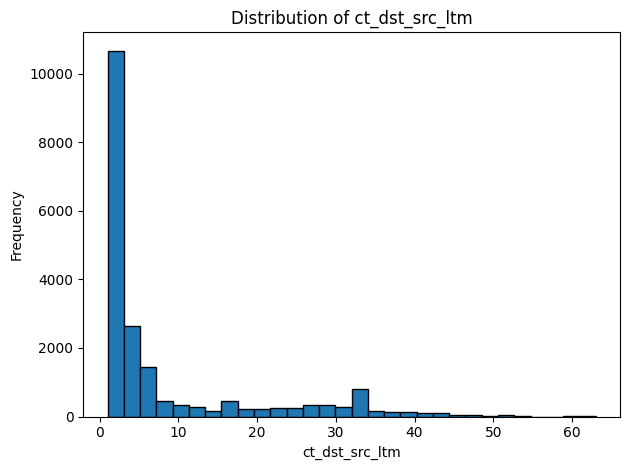

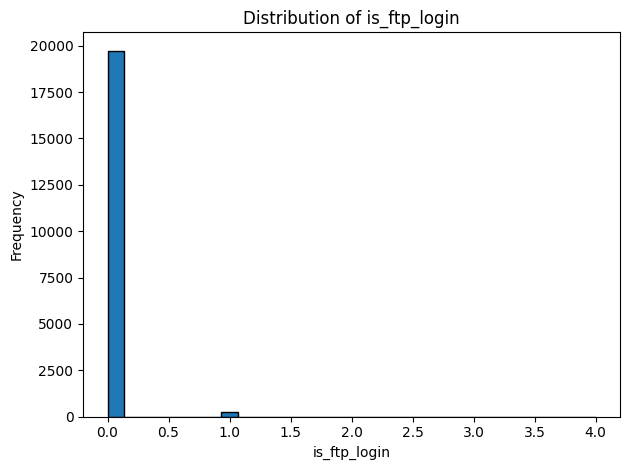

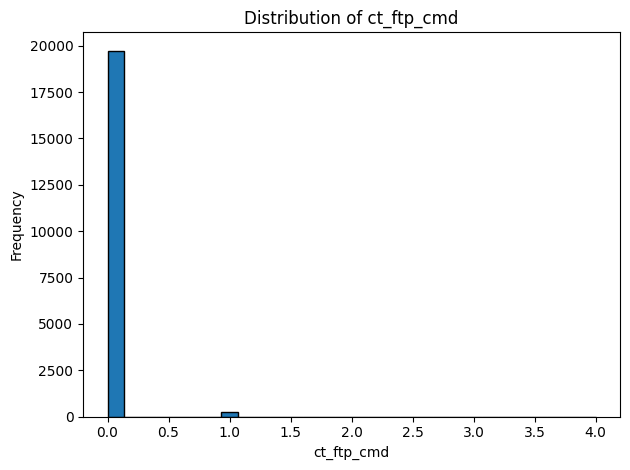

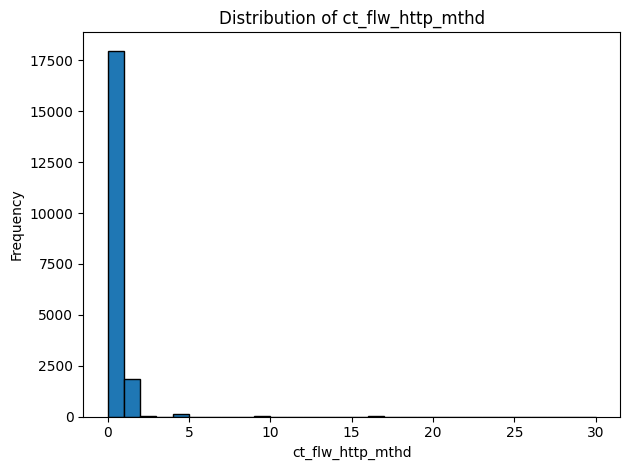

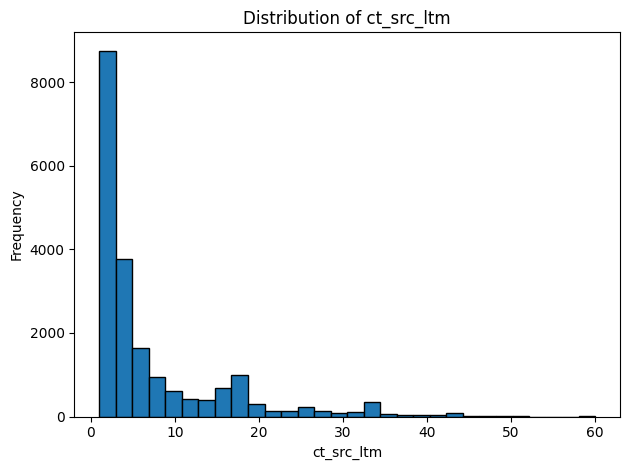

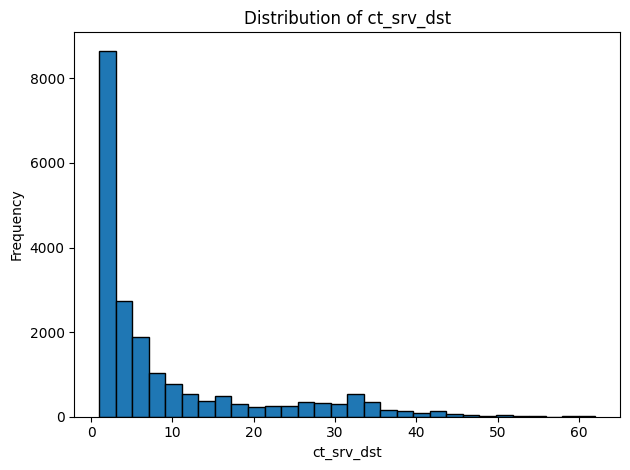

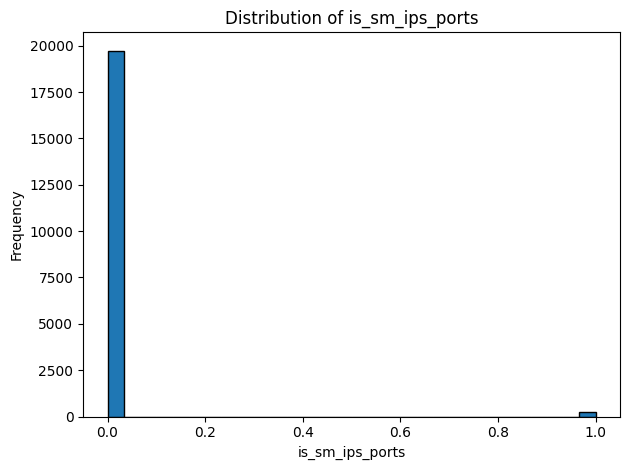

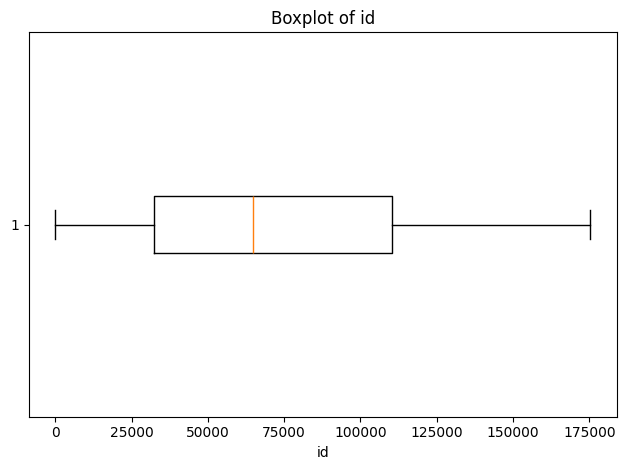

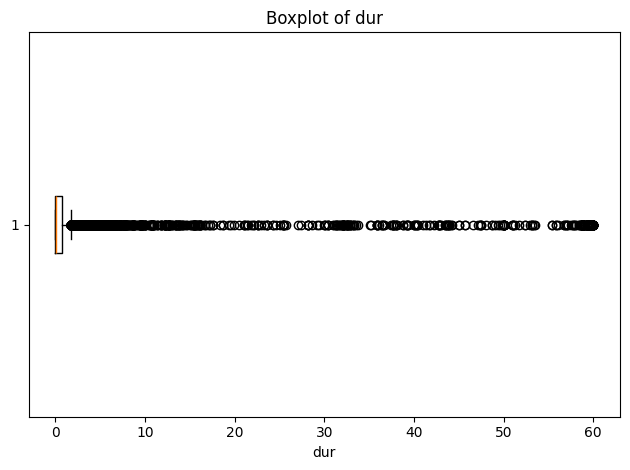

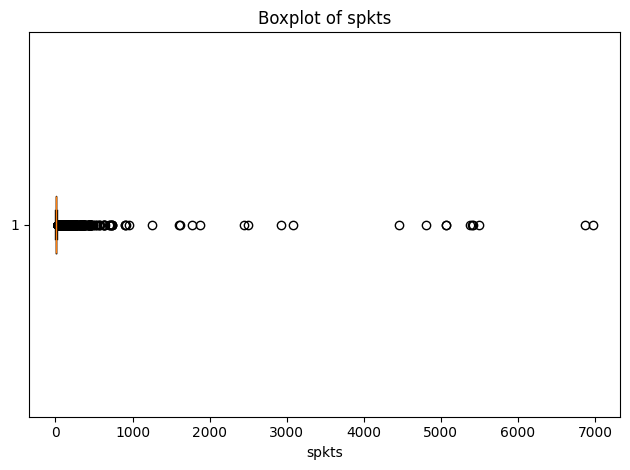

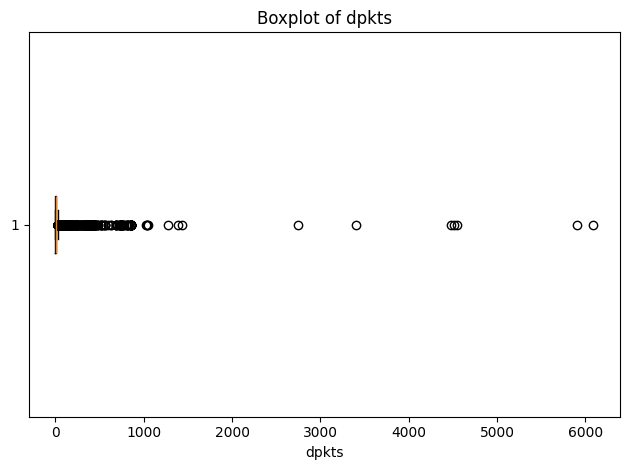

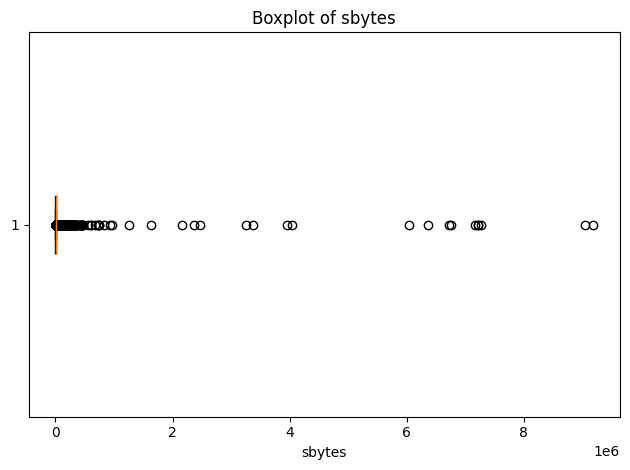

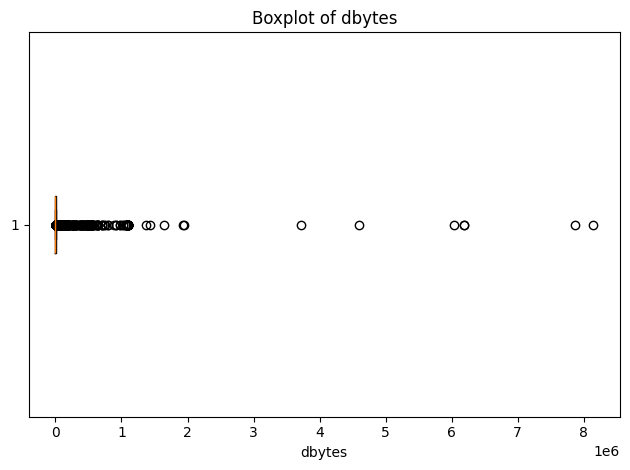

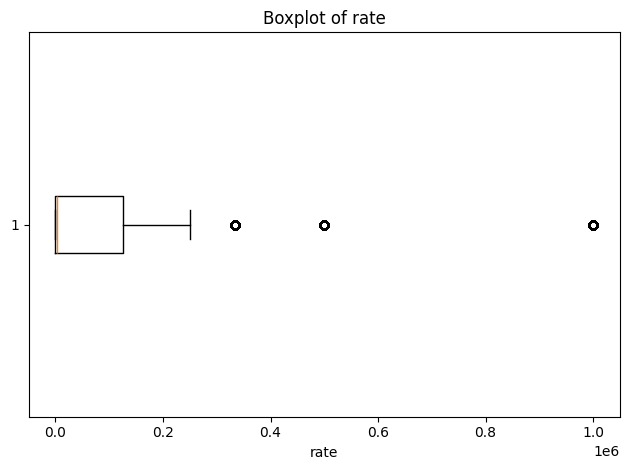

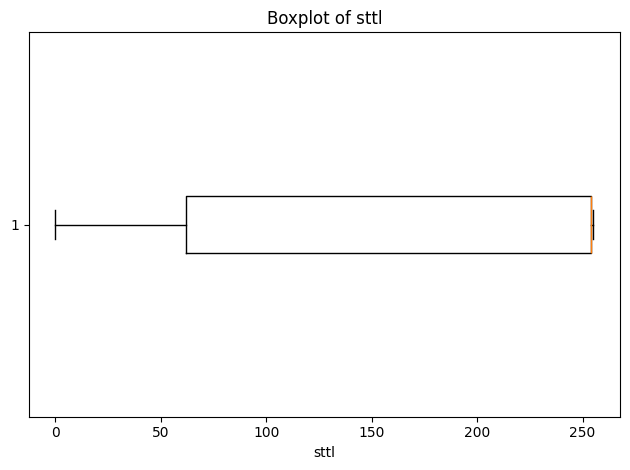

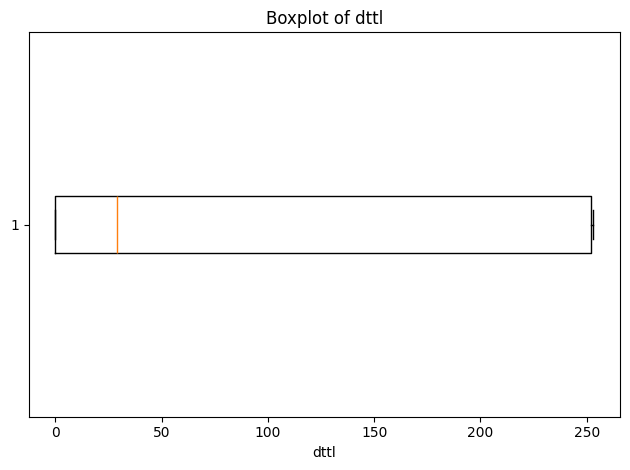

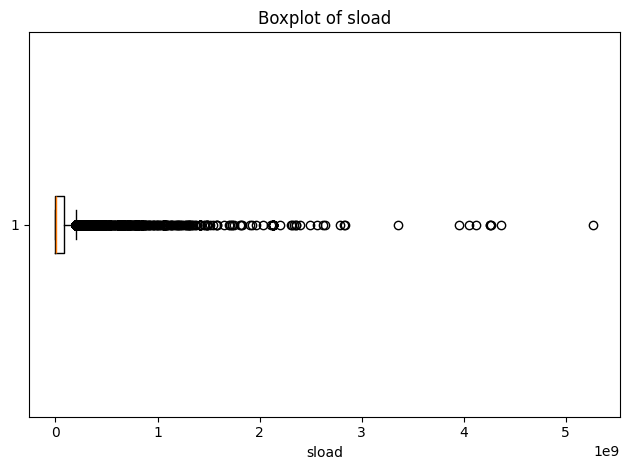

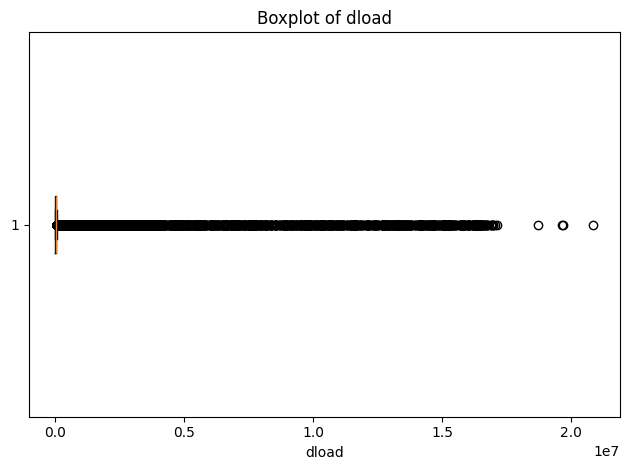

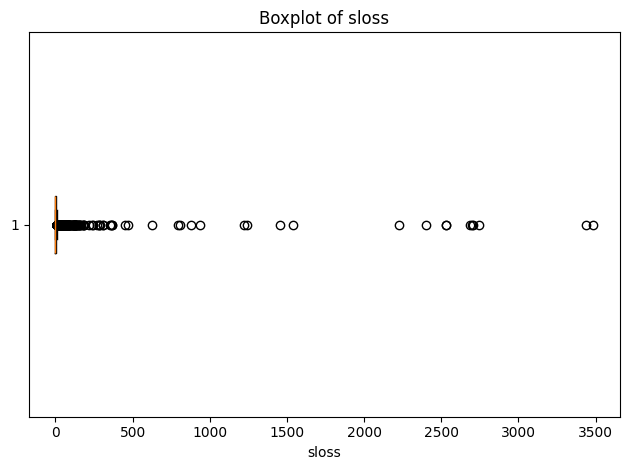

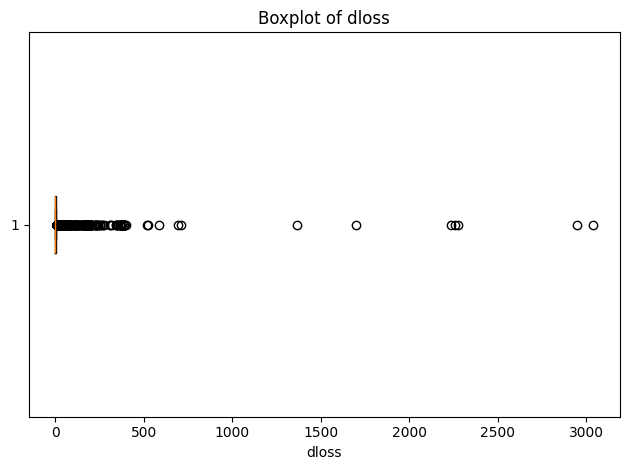

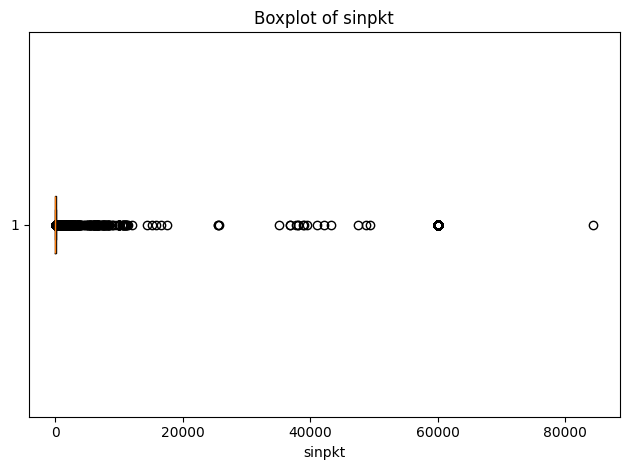

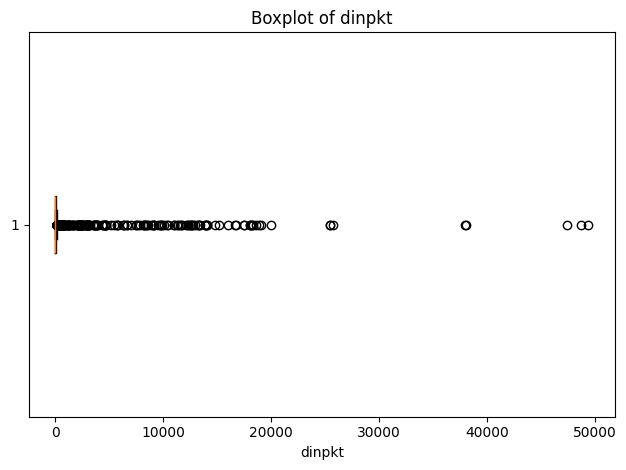

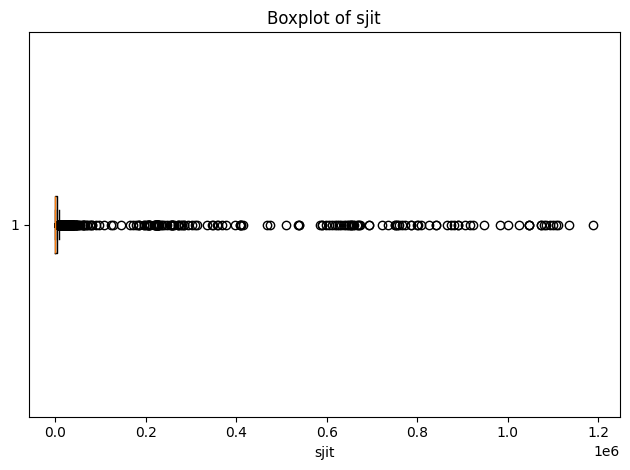

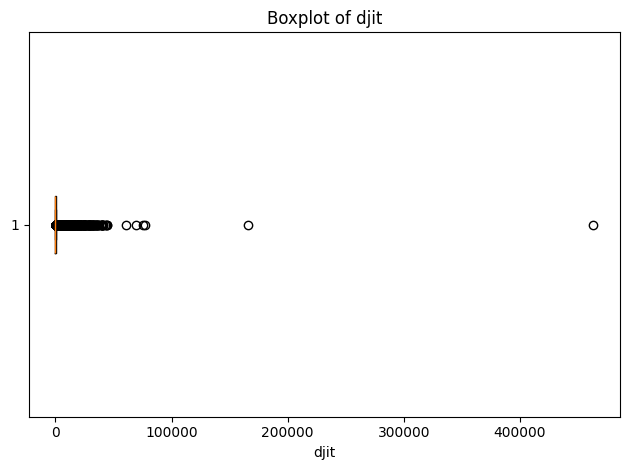

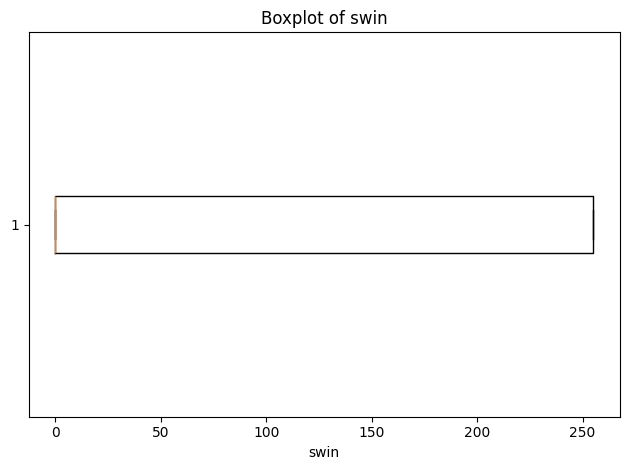

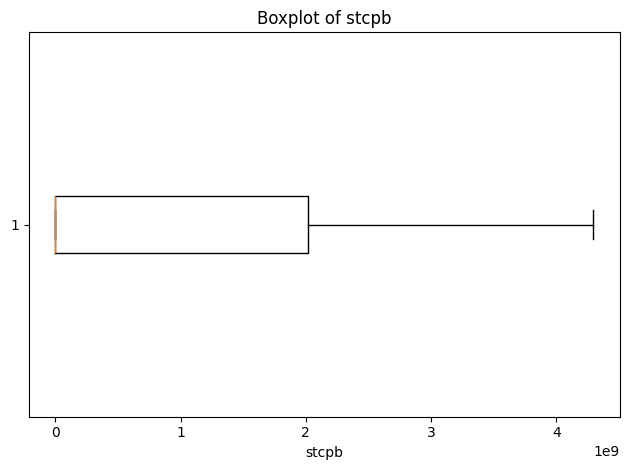

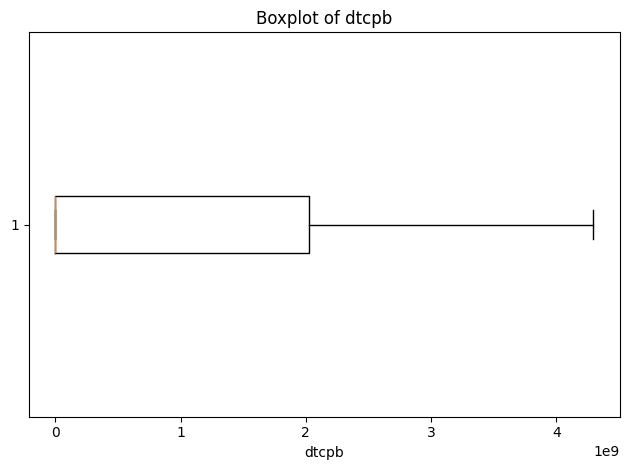

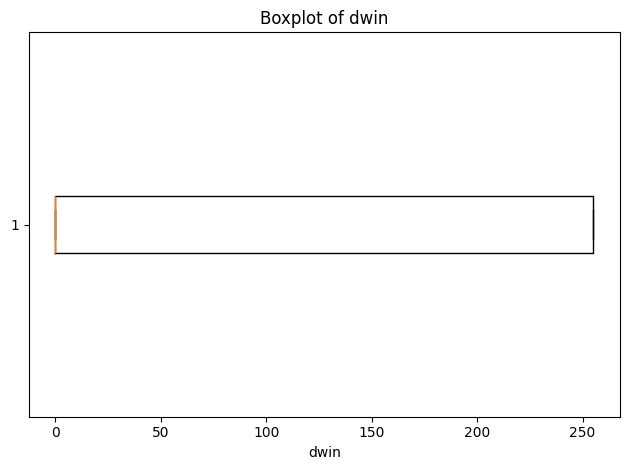

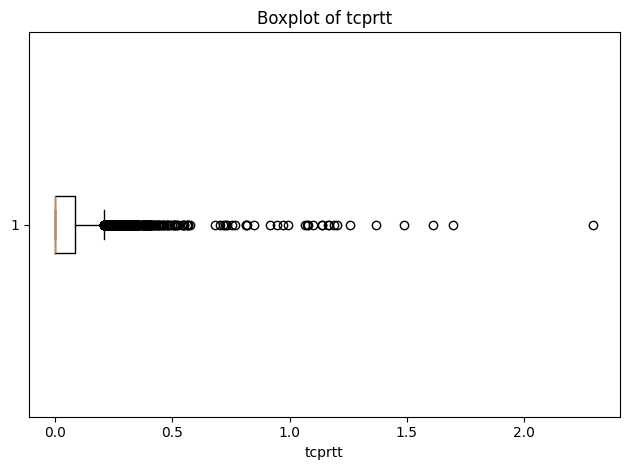

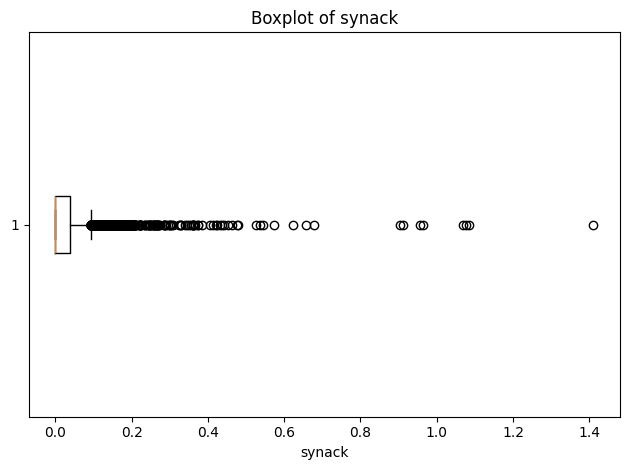

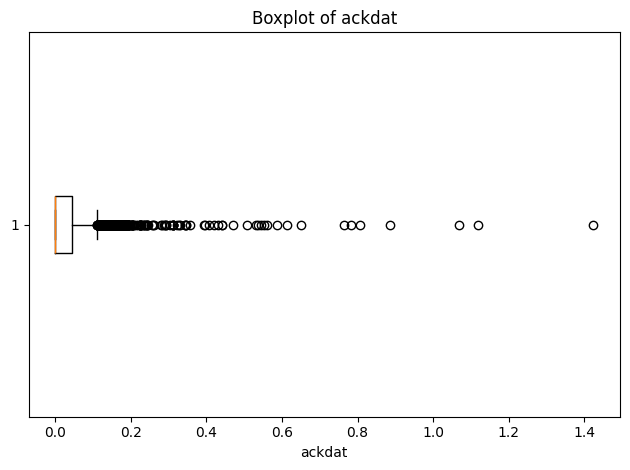

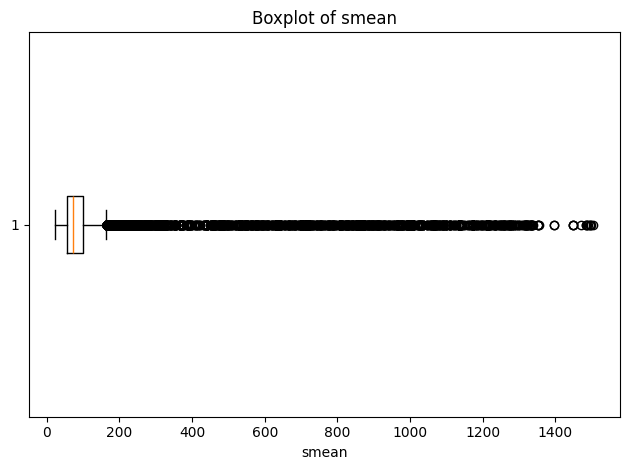

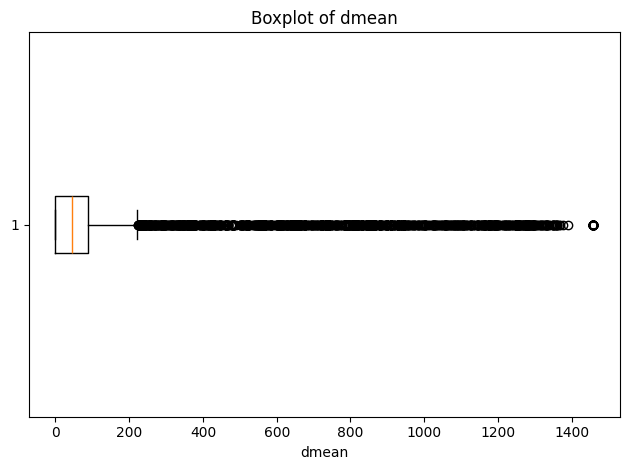

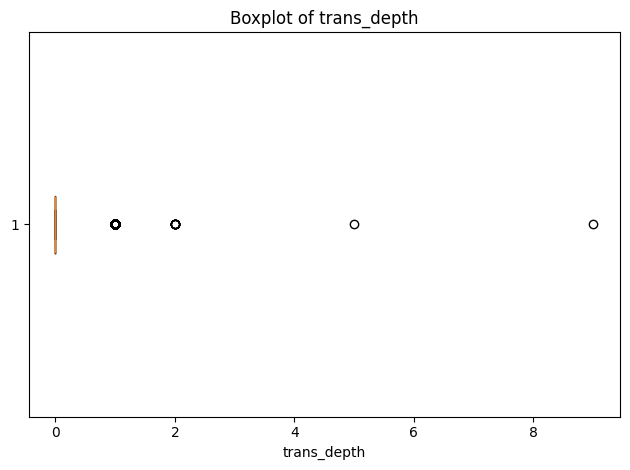

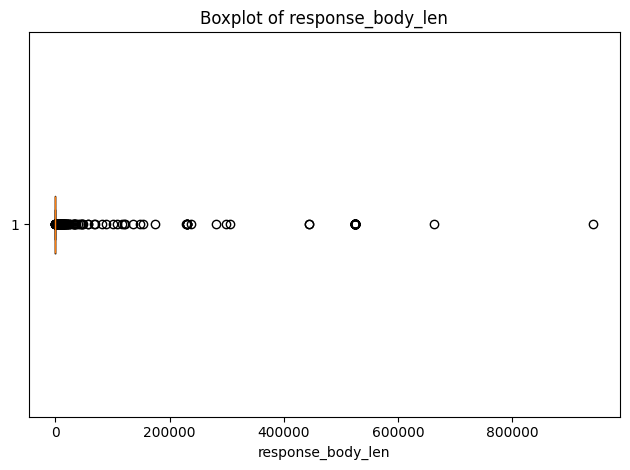

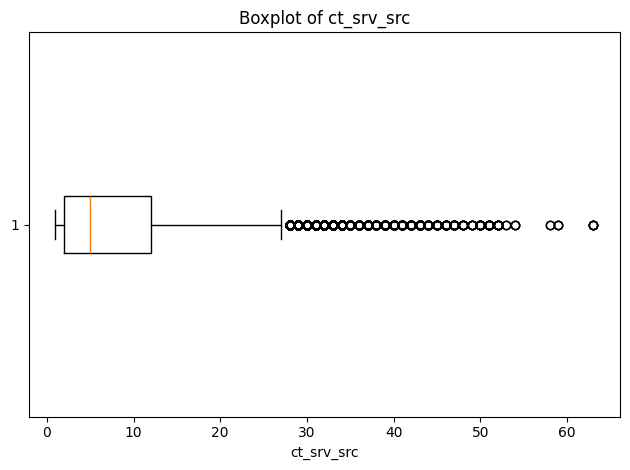

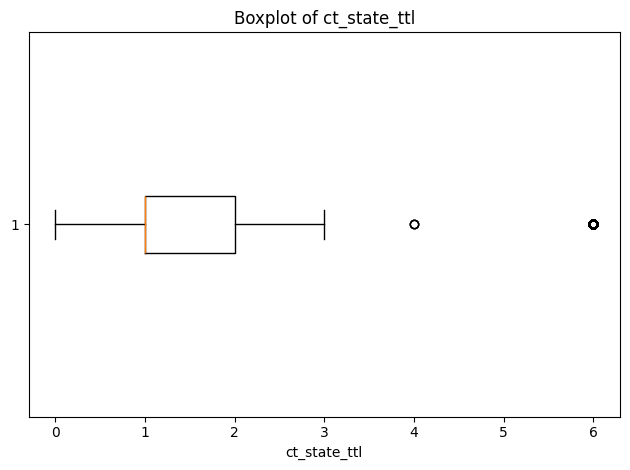

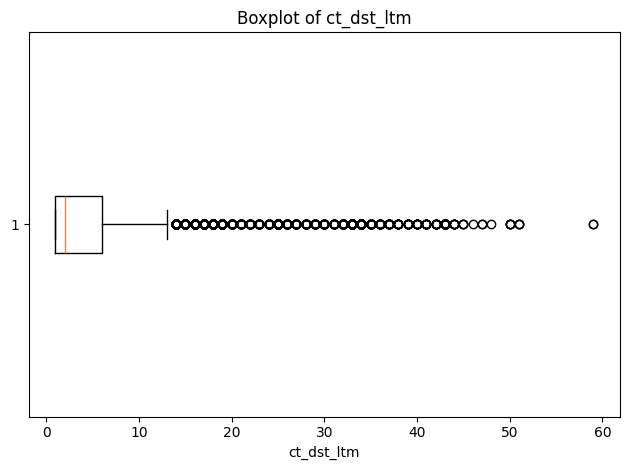

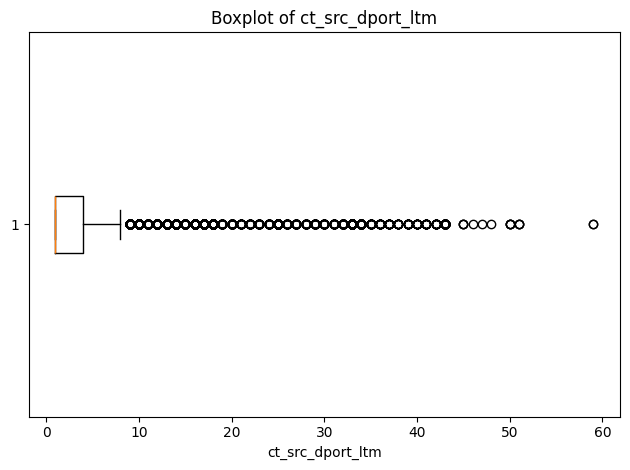

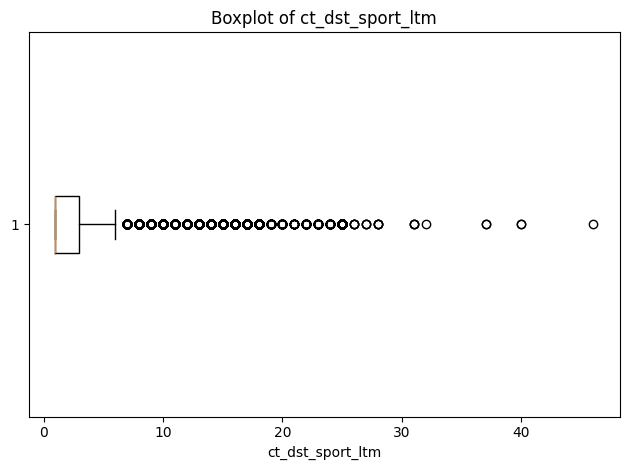

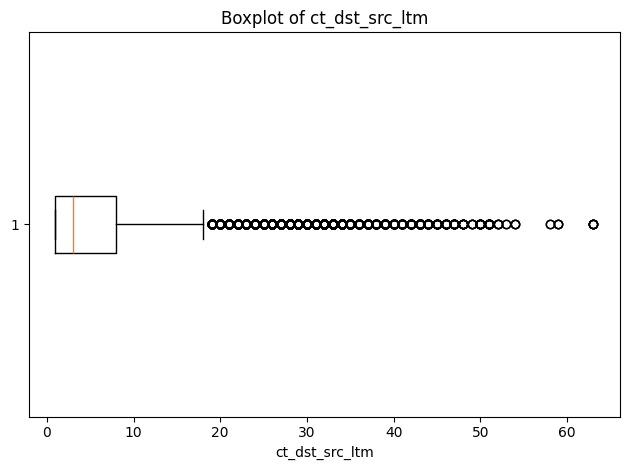

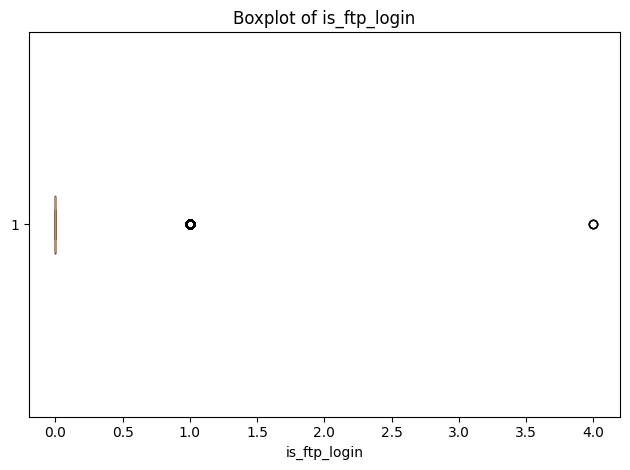

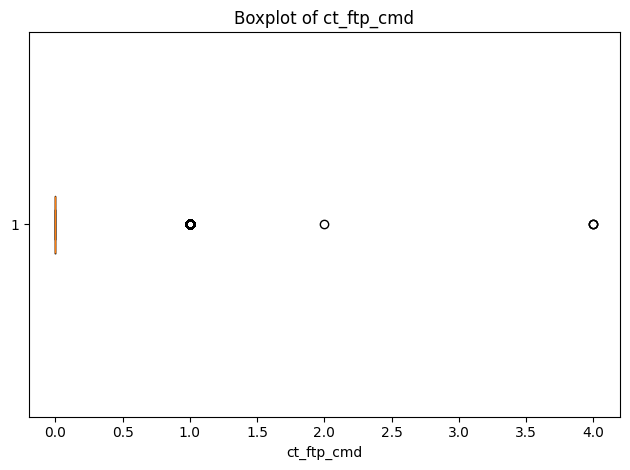

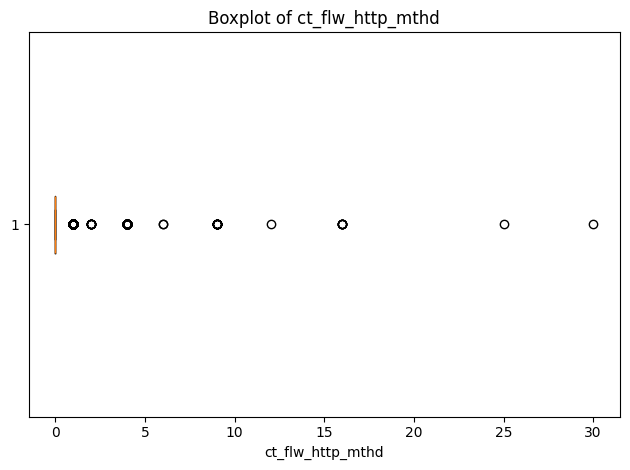

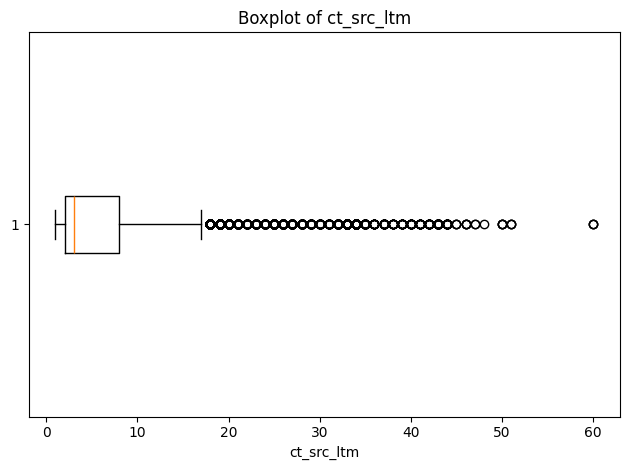

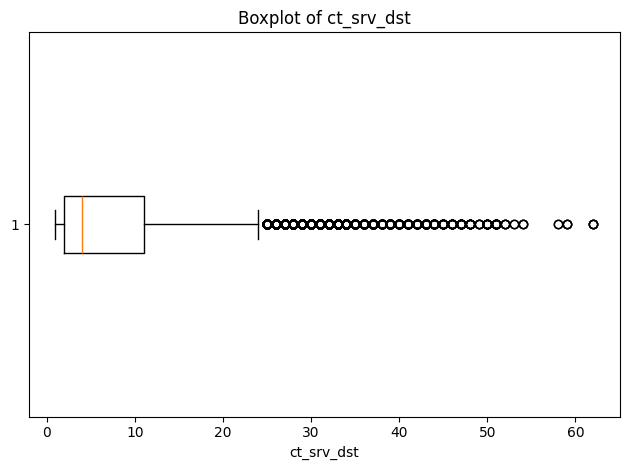

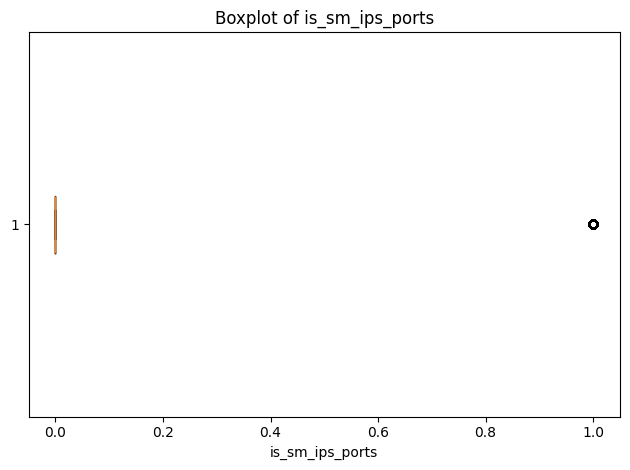

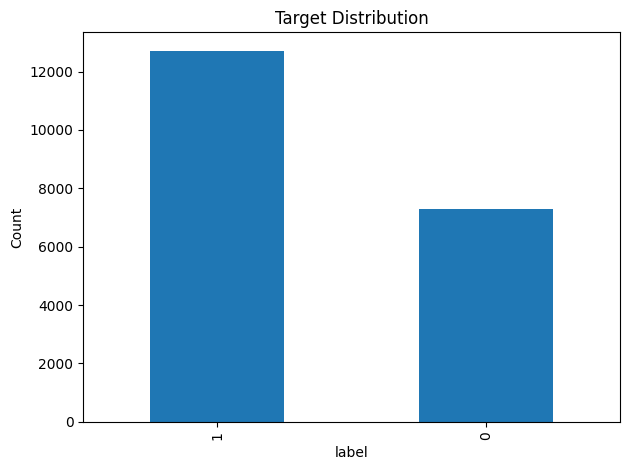

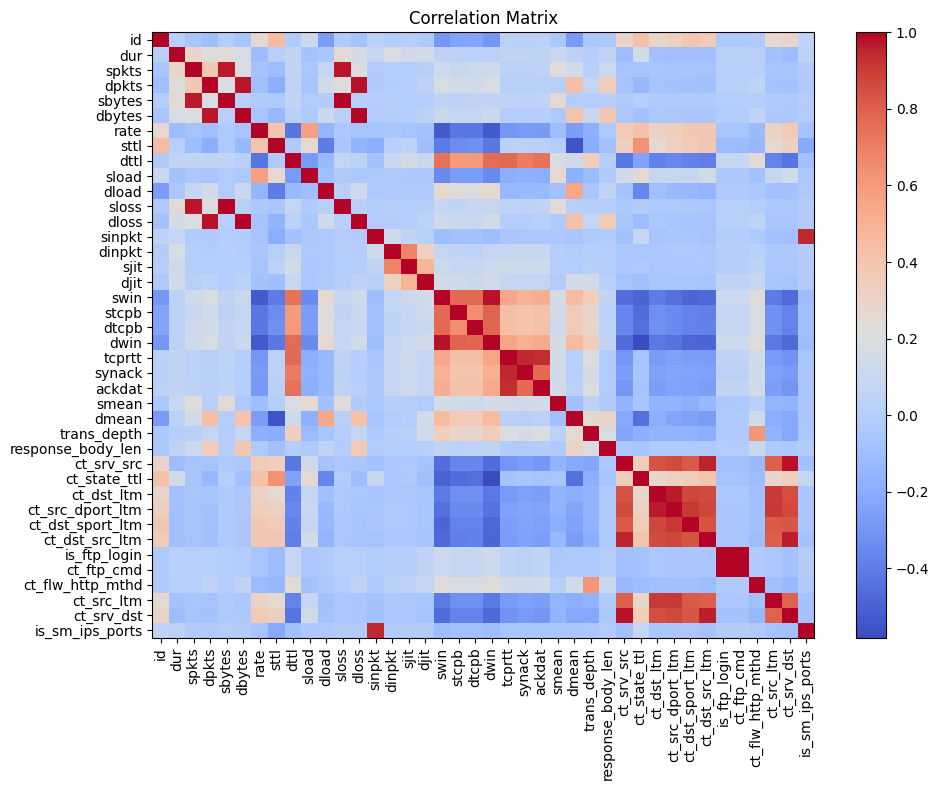

In [ ]:
# Advanced EDA
# Settting target column name here
target_col = 'label'

# Identify numeric and categorical features (excluding the target)
numeric_features = df.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
if target_col in numeric_features:
    numeric_features.remove(target_col)
if target_col in categorical_features:
    categorical_features.remove(target_col)

# Distribution plots for numeric features
for col in numeric_features:
    plt.figure()
    plt.hist(df[col].dropna(), bins=30, edgecolor='k')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Boxplots for numeric features to detect outliers
for col in numeric_features:
    plt.figure()
    plt.boxplot(df[col].dropna(), vert=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

# Bar plot for target variable distribution
plt.figure()
df[target_col].value_counts().plot(kind='bar')
plt.title('Target Distribution')
plt.xlabel(target_col)
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Correlation matrix heatmap for numeric features
if numeric_features:
    corr = df[numeric_features].corr()
    plt.figure(figsize=(10, 8))
    plt.imshow(corr, cmap='coolwarm', interpolation='none', aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(corr)), corr.columns, rotation=90)
    plt.yticks(range(len(corr)), corr.columns)
    plt.title("Correlation Matrix")
    plt.tight_layout()
    plt.show()

# Scatter matrix (if the number of features is reasonable)
if len(numeric_features) <= 10 and numeric_features:
    scatter_matrix(df[numeric_features], figsize=(12,12), diagonal='kde')
    plt.suptitle('Scatter Matrix of Numeric Features')
    plt.tight_layout()
    plt.show()


In [ ]:
#Data Preprocessing

# Separate features and target
X = df.drop(target_col, axis=1)
y = df[target_col]

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# Create transformers for numeric and categorical data
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Build the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

Numeric features: ['id', 'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports']
Categorical features: ['proto', 'service', 'state', 'attack_cat']


In [ ]:
#LazyClassifier Analysis

# LazyClassifier requires all numeric inputs. Convert categorical features using get_dummies.
X_dummy = pd.get_dummies(X)
X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy = train_test_split(
    X_dummy, y, test_size=0.2, random_state=42, stratify=y
)

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy)
# print(models)
print(models.sort_values(by="Accuracy", ascending=False))



  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 10168, number of negative: 5832
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5524
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.635500 -> initscore=0.555886
[LightGBM] [Info] Start training from score 0.555886
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
XGBClassifier                      0.98               0.98     0.98      0.98   
LGBMClassifier                     0.98               0.98     0.98      0.98   
BaggingClassifier                  0.97               0.97     0.97      0.97   
RandomForestClassifier             0.96 

In [ ]:
#Split Data for Hyperparameter Tuning
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# Hyperparameter Tuning on RandomForest
# Build a pipeline with the preprocessor and RandomForestClassifier
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Set up the parameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters Found:", grid_search.best_params_)
print("Best Cross-validation Accuracy: {:.4f}".format(grid_search.best_score_))
best_model = grid_search.best_estimator_

Best Parameters Found: {'classifier__max_depth': 20, 'classifier__n_estimators': 100}
Best Cross-validation Accuracy: 1.0000


=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1458
           1       1.00      1.00      1.00      2542

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000

Accuracy: 0.9995
=== Confusion Matrix ===
[[1456    2]
 [   0 2542]]


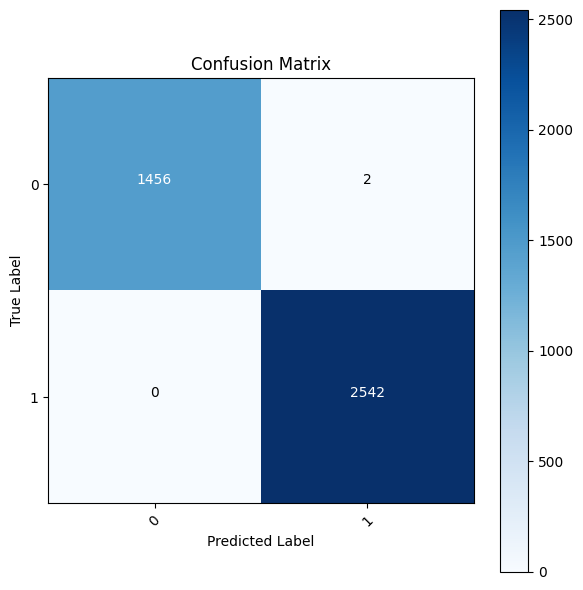

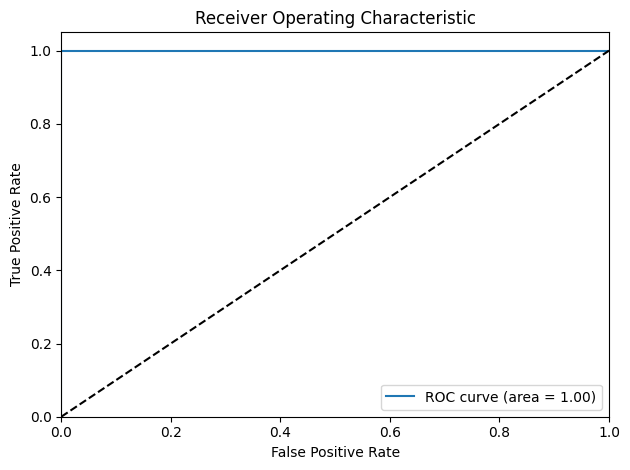

In [ ]:
# Evaluate the Tuned Model
y_pred = best_model.predict(X_test)
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("Accuracy:", accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("=== Confusion Matrix ===")
print(cm)

plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# If binary classification, plot the ROC curve.
if len(np.unique(y_test)) == 2:
    y_proba = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()



=== PCA + RandomForest Classification Report ===
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1458
           1       0.95      0.98      0.96      2542

    accuracy                           0.95      4000
   macro avg       0.95      0.94      0.95      4000
weighted avg       0.95      0.95      0.95      4000

=== Confusion Matrix ===
[[1329  129]
 [  63 2479]]


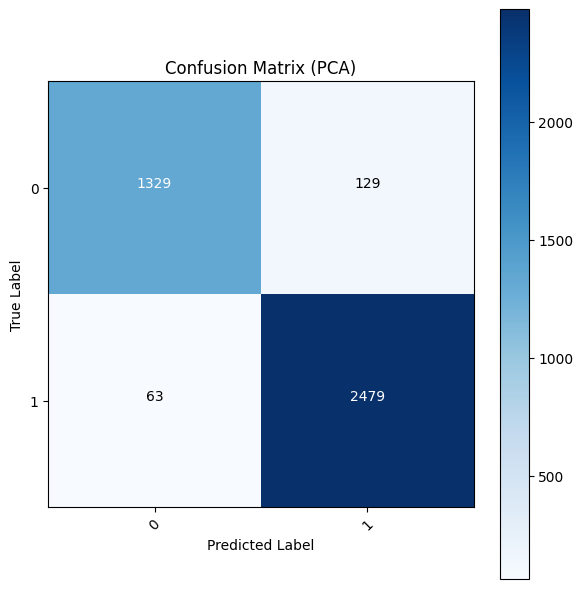

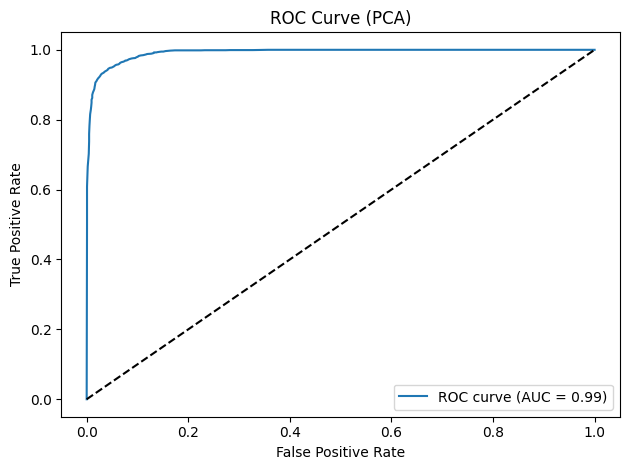

In [ ]:
# === PCA with RandomForest Pipeline ===
#Applying PCA to reduce dimensionality, minimize redundancy, and improve efficiency

# Define PCA and classifier
pca = PCA(n_components=10)
rf_clf = RandomForestClassifier(random_state=42)

# Build pipeline: preprocessing → PCA → classifier
pca_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', pca),
    ('classifier', rf_clf)
])

# Fit pipeline
pca_pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pca_pipeline.predict(X_test)
print("\n=== PCA + RandomForest Classification Report ===")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("=== Confusion Matrix ===")
print(cm)

plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (PCA)')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# ROC Curve (for binary classification)
if len(np.unique(y_test)) == 2:
    y_proba = pca_pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (PCA)')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


In [ ]:
# Scale after splitting to avoid information leakage
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE only to training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Build the ANN
model = Sequential()
model.add(Dense(64, input_dim=X_train_balanced.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    X_train_balanced, y_train_balanced,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# Predict
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Evaluation
print("=== ANN Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Epoch 1/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8577 - loss: 0.3359 - val_accuracy: 0.9985 - val_loss: 0.0113
Epoch 2/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9972 - loss: 0.0135 - val_accuracy: 0.9993 - val_loss: 0.0095
Epoch 3/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9997 - loss: 0.0030 - val_accuracy: 0.9993 - val_loss: 0.0084
Epoch 4/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9994 - loss: 0.0029 - val_accuracy: 0.9995 - val_loss: 0.0091
Epoch 5/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9995 - loss: 0.0025 - val_accuracy: 0.9998 - val_loss: 0.0079
Epoch 6/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9998 - loss: 9.0872e-04 - val_accuracy: 0.9995 - val_loss: 0.0100
Epoch 7/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9995 - loss: 0.0011 - val_accuracy: 0.9995 - val_loss: 0.0100
Epoch 8/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9999 - loss: 3.5894e-04 - val_accu

In [ ]:
#=== Fuzzy C-Means ===

# Standardize only numeric features
X_fcm = df[numeric_features].copy()
X_scaled = StandardScaler().fit_transform(X_fcm)

# Fuzzy C-Means Clustering
n_clusters = 2  # Since IDS is binary (attack or normal)
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    X_scaled.T, c=n_clusters, m=2, error=0.005, maxiter=1000
)

# Assign cluster labels based on max membership
fcm_labels = np.argmax(u, axis=0)

# Map cluster labels to actual class labels using majority voting
cluster_to_label = {}
for cluster in range(n_clusters):
    # Get the mode and handle cases where it's a scalar
    mode_result = mode(y[fcm_labels == cluster])
    # Check if mode_result.mode is an array or scalar
    majority_class = mode_result.mode[0] if isinstance(mode_result.mode, np.ndarray) and mode_result.count[0] > 0 else mode_result.mode if mode_result.count > 0 else y[fcm_labels == cluster].iloc[0] #If mode is empty, using first element.
    # If mode_result.mode is a scalar, use it directly; otherwise, access the first element
    cluster_to_label[cluster] = majority_class

# Convert fuzzy cluster labels to predicted class labels
fcm_pred = np.array([cluster_to_label[label] for label in fcm_labels])

# Add to DataFrame (optional)
df['fuzzy_cluster'] = fcm_labels
df['fcm_predicted_class'] = fcm_pred

# Evaluate
print("=== Fuzzy C-Means Results ===")
print("Accuracy:", accuracy_score(y, fcm_pred))
print("Confusion Matrix:\n", confusion_matrix(y, fcm_pred))
print("Classification Report:\n", classification_report(y, fcm_pred))

=== Fuzzy C-Means Results ===
Accuracy: 0.6749
Confusion Matrix:
 [[5104 2186]
 [4316 8394]]
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.70      0.61      7290
           1       0.79      0.66      0.72     12710

    accuracy                           0.67     20000
   macro avg       0.67      0.68      0.67     20000
weighted avg       0.70      0.67      0.68     20000



In [ ]:
#=== Fuzzy C-Means ===

# Standardize only numeric features
X_fcm = df[numeric_features].copy()
X_scaled = StandardScaler().fit_transform(X_fcm)

# Fuzzy C-Means Clustering with n_clusters and m tuning
n_clusters_range = [2, 3, 4, 5]
m_range = [1.5, 1.7, 1.8, 2.0]

best_accuracy = 0
best_params = (None, None)

# Loop through different n_clusters and m values
for n in n_clusters_range:
    for m in m_range:
        # Perform fuzzy clustering
        cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(X_scaled.T, c=n, m=m, error=0.005, maxiter=1000)
        fcm_labels = np.argmax(u, axis=0)  # Assign clusters based on max membership

        # Create cluster_to_label mapping for this iteration
        cluster_to_label = {}
        for cluster in range(n):  # Use 'n' (number of clusters) here
            mode_result = mode(y[fcm_labels == cluster])
            majority_class = mode_result.mode[0] if isinstance(mode_result.mode, np.ndarray) and mode_result.count[0] > 0 else mode_result.mode if mode_result.count > 0 else y[fcm_labels == cluster].iloc[0]
            cluster_to_label[cluster] = majority_class

        fcm_pred = np.array([cluster_to_label[label] for label in fcm_labels])

        # Compute accuracy
        accuracy = accuracy_score(y, fcm_pred)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = (n, m)

print(f"Best n_clusters: {best_params[0]}, Best m: {best_params[1]}, Accuracy: {best_accuracy}")


# Re-run the best configuration with the final clustering
n_clusters = best_params[0]
m = best_params[1]
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(X_scaled.T, c=n_clusters, m=m, error=0.005, maxiter=1000)

# Assign cluster labels based on max membership
fcm_labels = np.argmax(u, axis=0)

# Map cluster labels to actual class labels using majority voting
cluster_to_label = {}
for cluster in range(n_clusters):
    mode_result = mode(y[fcm_labels == cluster])
    majority_class = mode_result.mode[0] if isinstance(mode_result.mode, np.ndarray) and mode_result.count[0] > 0 else mode_result.mode if mode_result.count > 0 else y[fcm_labels == cluster].iloc[0]
    cluster_to_label[cluster] = majority_class

# Convert fuzzy cluster labels to predicted class labels
fcm_pred = np.array([cluster_to_label[label] for label in fcm_labels])

# Add to DataFrame (optional)
df['fuzzy_cluster'] = fcm_labels
df['fcm_predicted_class'] = fcm_pred

# Evaluate performance
print("=== Fuzzy C-Means Results ===")
print("Accuracy:", accuracy_score(y, fcm_pred))
print("Confusion Matrix:\n", confusion_matrix(y, fcm_pred))
print("Classification Report:\n", classification_report(y, fcm_pred))

# Optionally, also evaluate the silhouette score
from sklearn.metrics import silhouette_score
sil_score = silhouette_score(X_scaled, fcm_labels)
print(f"Silhouette Score: {sil_score}")


Best n_clusters: 5, Best m: 1.8, Accuracy: 0.8258
=== Fuzzy C-Means Results ===
Accuracy: 0.8259
Confusion Matrix:
 [[ 3841  3449]
 [   33 12677]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.53      0.69      7290
           1       0.79      1.00      0.88     12710

    accuracy                           0.83     20000
   macro avg       0.89      0.76      0.78     20000
weighted avg       0.86      0.83      0.81     20000

Silhouette Score: 0.29087045914163373


=== SHAP Summary Plot ===


<Figure size 640x480 with 0 Axes>

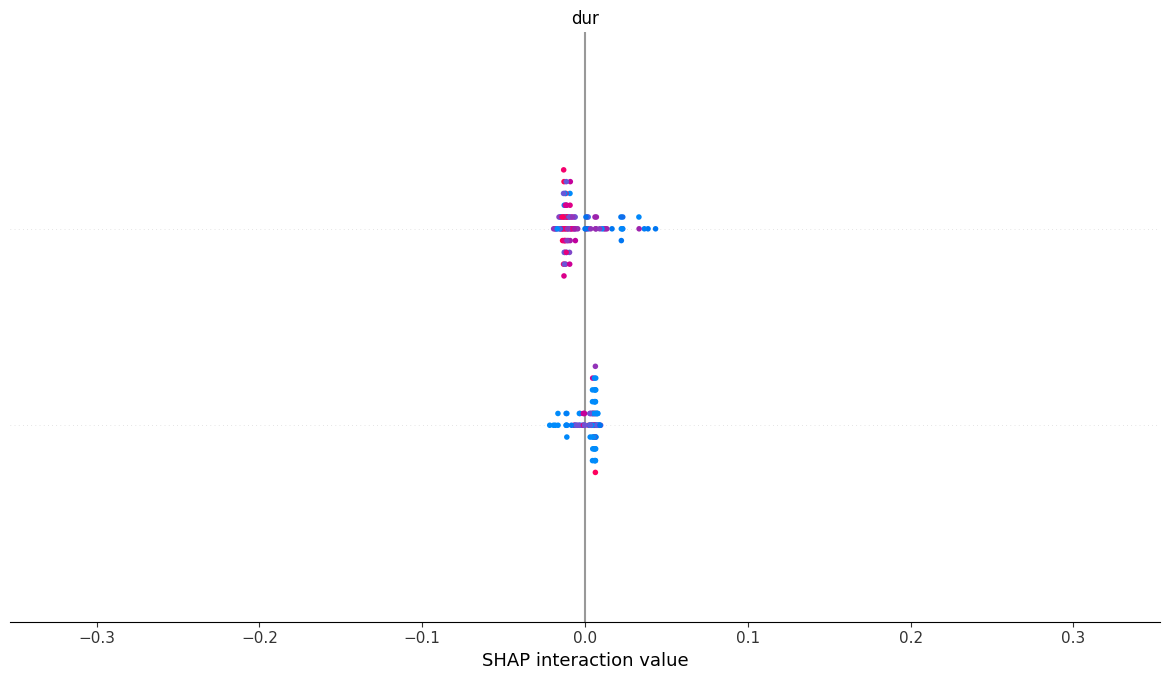

In [ ]:
import shap
import numpy as np
from sklearn.model_selection import train_test_split

# # Keeping this Split code here as sometimes need to  run  as further code was giving issue
# # Split Data for Hyperparameter Tuning
# X_train, X_test, y_train, y_test = train_test_split(
#     df.drop(target_col, axis=1),
#     y,
#     test_size=0.2,
#     random_state=42,
#     stratify=y
# )

# Transform the training set using the pipeline preprocessor (fit and transform)
X_train_transformed = best_model.named_steps['preprocessor'].fit_transform(X_train)

# Transform the test set using the pipeline preprocessor (only transform)
X_test_transformed = best_model.named_steps['preprocessor'].transform(X_test)

# Ensure that both X_train_transformed and X_test_transformed have the correct format
if hasattr(X_train_transformed, "toarray"):
    X_train_transformed = X_train_transformed.toarray()  # Convert sparse matrix to dense
if hasattr(X_test_transformed, "toarray"):
    X_test_transformed = X_test_transformed.toarray()  # Convert sparse matrix to dense

X_train_transformed = X_train_transformed.astype(np.float64)
X_test_transformed = X_test_transformed.astype(np.float64)

# Feature names after preprocessing (assuming you're using one-hot encoding for categorical features)
try:
    # Get feature names for categorical features if available
    cat_feature_names = best_model.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
except AttributeError:
    # If the model doesn't have 'get_feature_names_out', use the older method
    cat_feature_names = best_model.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names(categorical_features)

# Combine numeric features and categorical features for the feature names
feature_names = numeric_features + list(cat_feature_names)

# === SHAP Explainability Analysis ===
print("\n--- SHAP Analysis for Tuned RandomForest Model --- ")
try:
    # 1. Get the fitted preprocessor and classifier from the best RF pipeline
    fitted_preprocessor = best_model.named_steps['preprocessor']
    classifier_shap = best_model.named_steps['classifier']

    # 2. Transform the test set using the *same* preprocessor
    X_test_transformed_shap = fitted_preprocessor.transform(X_test)

    # 3. Get feature names after preprocessing
    processed_feature_names_shap = None
    try:
        # Get numeric and categorical feature names
        numeric_features_tf = fitted_preprocessor.transformers_[0][2]
        categorical_features_tf = fitted_preprocessor.transformers_[1][2]
        ohe_transformer = fitted_preprocessor.named_transformers_['cat']['onehot']
        cat_feature_names_shap = ohe_transformer.get_feature_names_out(categorical_features_tf)
        processed_feature_names_shap = list(numeric_features_tf) + list(cat_feature_names_shap)
        print(f"Number of features for SHAP: {len(processed_feature_names_shap)}")
    except Exception as e:
        print(f"Could not retrieve feature names for SHAP: {e}. Using generic names.")
        num_processed_features = X_test_transformed_shap.shape[1]
        processed_feature_names_shap = [f'feature_{i}' for i in range(num_processed_features)]

    # 4. Create SHAP Explainer
    explainer = shap.TreeExplainer(classifier_shap)

    # 5. Calculate SHAP values (use a sample for speed)
    X_test_transformed_df_shap = pd.DataFrame(X_test_transformed_shap, columns=processed_feature_names_shap)
    sample_size_shap = min(100, X_test_transformed_df_shap.shape[0])
    if sample_size_shap > 0:
        X_sample_shap = X_test_transformed_df_shap.sample(sample_size_shap, random_state=42)
        print(f"Calculating SHAP values for {sample_size_shap} samples...")
        shap_values = explainer.shap_values(X_sample_shap)

        # --- Print SHAP Values and Feature Importance ---
        if isinstance(shap_values, list) and len(shap_values) == 2:
            shap_values_class1 = shap_values[1] # Focus on the positive class (attack)
            mean_abs_shap = np.abs(shap_values_class1).mean(axis=0)
            feature_importance = pd.Series(mean_abs_shap, index=processed_feature_names_shap)
            feature_importance_sorted = feature_importance.sort_values(ascending=False)

            print("\n=== Mean Absolute SHAP Values (Feature Importance) ===")
            print(feature_importance_sorted)
            print("\n=== Top 10 Most Important Features ===")
            print(feature_importance_sorted.head(10))

            # 6. Generate SHAP summary plot (for Class 1)
            print("\n=== SHAP Summary Plot (Class 1 - Attack) ===")
            shap.summary_plot(shap_values_class1, X_sample_shap, show=False)
            plt.title("SHAP Summary Plot (Class 1 - Attack)")
            plt.show()
        else:
            mean_abs_shap = np.abs(shap_values).mean(axis=0)
            feature_importance = pd.Series(mean_abs_shap, index=processed_feature_names_shap)
            print("\n=== Mean Absolute SHAP Values ===")
            print(feature_importance.sort_values(ascending=False))
            print("\n=== SHAP Summary Plot ===")
            shap.summary_plot(shap_values, X_sample_shap, show=False)
            plt.title("SHAP Summary Plot")
            plt.show()
    else:
        print("Not enough samples to calculate SHAP values.")

except Exception as e:
    print(f"An error occurred during SHAP analysis: {e}")
    import traceback
    traceback.print_exc()


In [ ]:
print("Categorical features:", categorical_features)


print("Number of features in SHAP plot:", len(feature_names))

Categorical features: ['proto', 'service', 'state', 'attack_cat']
Number of features in SHAP plot: 201
